In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
base = automap_base()

# reflect the tables
base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Find the Max Date
max_date = session.query(func.max(func.strftime("%Y-%m-%d", measurement.date))).limit(5).all()
max_date[0][0]

'2017-08-23'

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results to calculate the date 1 year ago from the last data point in the database.
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(func.strftime("%Y-%m-%d", measurement.date), measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", measurement.date) >= dt.date(2016, 9, 23)).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation_data, columns = ['date', 'precipitation'])

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.set_index('date', inplace = True)

# View the Dataframe
precipitation_df.head()

,precipitation
date,
2016-09-23,0.00
2016-09-23,0.00
2016-09-23,0.00
2016-09-23,0.15
2016-09-23,0.15


In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation
count,1846.000000
mean,0.161056
std,0.422000
min,0.000000
25%,0.000000
50%,0.010000
75%,0.120000
max,6.250000


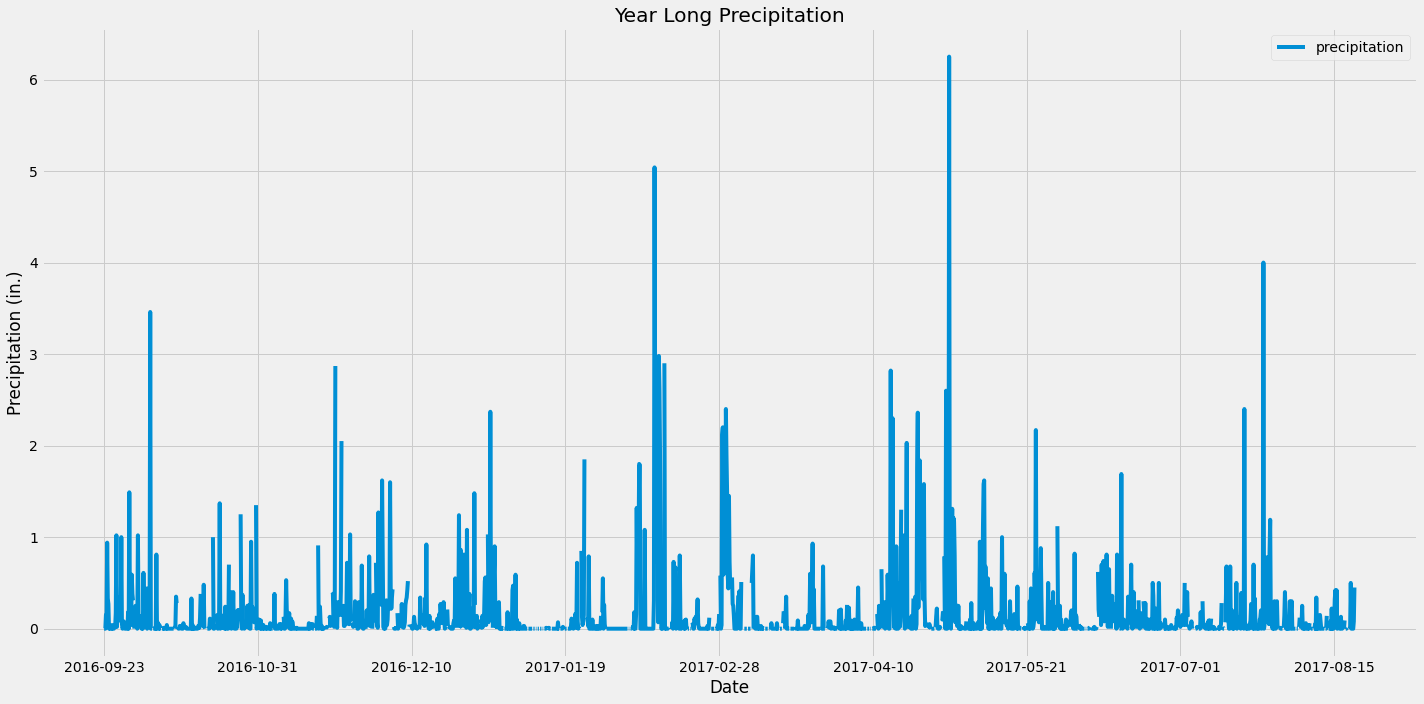

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_df.plot(ax = ax, x_compat = True)

#title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation")

plt.savefig("Images/precipitation_15to16.png")

#plot
plt.tight_layout()
plt.show()

In [14]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(station.id).distinct().count()
stations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_counts = (session.query(measurement.station, func.count(measurement.station))
                        .group_by(measurement.station)
                        .order_by(func.count(measurement.station).desc())
                        .all())
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station = 'USC00519281'
temps = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_active_station).all()
temps

[(54.0, 85.0, 71.66378066378067)]

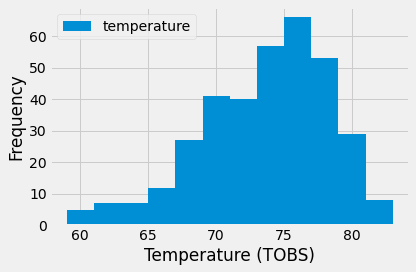

In [17]:
# Choose the station with the highest number of temperature observations.
temp_observation = session.query(measurement.date, measurement.tobs).filter(measurement.station == most_active_station).\
    filter(func.strftime("%Y-%m-%d", measurement.date) >= dt.date(2016, 8, 23)).all()

# Save as a data frame
temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])
fig, ax = plt.subplots()
temp_observation_df.plot.hist(bins = 12, ax = ax)

#labels
ax.set_xlabel('Temperature (TOBS)')
ax.set_ylabel('Frequency')

# Save figure
plt.savefig("Images/yearly_temp_plot.png")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2013-07-28', '2013-07-31'))

[(72.0, 76.78571428571429, 82.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2016-09-20','2016-10-05')
trip_temps

[(70.0, 78.04716981132076, 83.0)]

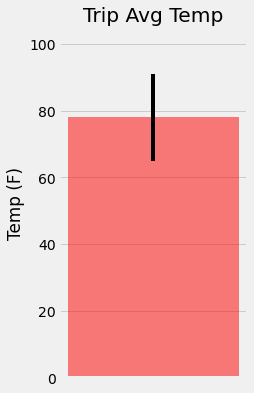

In [20]:
# Plot the results from your previous query as a bar chart.
min_temp = trip_temps[0][0]
avg_temp = trip_temps[0][1]
max_temp = trip_temps[0][2]

min_error = avg_temp - min_temp
max_error = max_temp - avg_temp

plt.figure(figsize=(3,6))

# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar(0, avg_temp, yerr=[max_temp-min_temp], color = 'red', alpha=.5)

# Use "Trip Avg Temp" as your Title
plt.title('Trip Avg Temp')
plt.ylim(0,105)
plt.ylabel('Temp (F)')
plt.xticks([])

plt.show()

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2016-09-20'
end_date = '2016-10-05'

station_weather = session.query(station.station,
                  func.sum(measurement.prcp),
                  station.name,
                  station.elevation,                                    
                  station.latitude,
                  station.longitude)\
.filter(measurement.station == station.station)\
.filter(measurement.date >= start_date)\
.filter(measurement.date <= end_date)\
.group_by(station.station)\
.order_by(func.sum(measurement.prcp).desc())

for row in station_weather:
    rain="{0:.2f}".format(row[1])
    print (f"Station:  {row[0]}\n    Rainfall:  {rain}  \n    Location:  {row[2]}\n    Elevation:  {row[3]}  \
    Latitude:  {row[4]}  Longitude:  {row[5]}")
    print()

Station:  USC00516128
    Rainfall:  13.14  
    Location:  MANOA LYON ARBO 785.2, HI US
    Elevation:  152.4      Latitude:  21.3331  Longitude:  -157.8025

Station:  USC00519281
    Rainfall:  3.19  
    Location:  WAIHEE 837.5, HI US
    Elevation:  32.9      Latitude:  21.45167  Longitude:  -157.84888999999998

Station:  USC00513117
    Rainfall:  1.67  
    Location:  KANEOHE 838.1, HI US
    Elevation:  14.6      Latitude:  21.4234  Longitude:  -157.8015

Station:  USC00514830
    Rainfall:  1.01  
    Location:  KUALOA RANCH HEADQUARTERS 886.9, HI US
    Elevation:  7.0      Latitude:  21.5213  Longitude:  -157.8374

Station:  USC00519523
    Rainfall:  0.84  
    Location:  WAIMANALO EXPERIMENTAL FARM, HI US
    Elevation:  19.5      Latitude:  21.33556  Longitude:  -157.71139

Station:  USC00519397
    Rainfall:  0.10  
    Location:  WAIKIKI 717.2, HI US
    Elevation:  3.0      Latitude:  21.2716  Longitude:  -157.8168

Station:  USC00517948
    Rainfall:  0.10  
    Locati

In [23]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
#create a list of dates
trip_dates = ["09-20", "09-21", "09-22", "09-23", "09-24", "09-25", "09-26", "09-27", "09-28", "09-29", "09-30",
             "10-01", "10-02", "10-03", "10-04", "10-05"]

# Use the start and end date to create a range of dates to calculate trip length
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
daily_norms = []

for trip_date in trip_dates:
    day = {}
    day['Date'] = f"2019-{trip_date}"
    daily_norm = daily_normals(trip_date)
    day['Min'] = daily_norm[0][0]
    day['Avg'] = daily_norm[0][1]
    day['Max'] = daily_norm[0][2]
    daily_norms.append(day)
    
daily_norms

[{'Date': '2019-09-20', 'Min': 69.0, 'Avg': 76.14583333333333, 'Max': 83.0},
 {'Date': '2019-09-21', 'Min': 67.0, 'Avg': 76.44897959183673, 'Max': 84.0},
 {'Date': '2019-09-22', 'Min': 69.0, 'Avg': 76.37254901960785, 'Max': 84.0},
 {'Date': '2019-09-23', 'Min': 67.0, 'Avg': 75.82692307692308, 'Max': 83.0},
 {'Date': '2019-09-24', 'Min': 69.0, 'Avg': 77.02, 'Max': 85.0},
 {'Date': '2019-09-25', 'Min': 69.0, 'Avg': 76.14893617021276, 'Max': 83.0},
 {'Date': '2019-09-26', 'Min': 66.0, 'Avg': 75.64, 'Max': 85.0},
 {'Date': '2019-09-27', 'Min': 68.0, 'Avg': 75.64, 'Max': 83.0},
 {'Date': '2019-09-28', 'Min': 67.0, 'Avg': 76.13461538461539, 'Max': 84.0},
 {'Date': '2019-09-29', 'Min': 68.0, 'Avg': 75.97872340425532, 'Max': 83.0},
 {'Date': '2019-09-30', 'Min': 67.0, 'Avg': 75.3061224489796, 'Max': 83.0},
 {'Date': '2019-10-01', 'Min': 69.0, 'Avg': 75.22916666666667, 'Max': 80.0},
 {'Date': '2019-10-02', 'Min': 70.0, 'Avg': 76.26, 'Max': 83.0},
 {'Date': '2019-10-03', 'Min': 66.0, 'Avg': 76.7

In [28]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
daily_norms_df = pd.DataFrame(daily_norms)
daily_norms_df.set_index('Date', inplace = True)
daily_norms_df

,Min,Avg,Max
Date,,,
2019-09-20,69.0,76.145833,83.0
2019-09-21,67.0,76.448980,84.0
2019-09-22,69.0,76.372549,84.0
2019-09-23,67.0,75.826923,83.0
2019-09-24,69.0,77.020000,85.0
2019-09-25,69.0,76.148936,83.0
2019-09-26,66.0,75.640000,85.0
2019-09-27,68.0,75.640000,83.0
2019-09-28,67.0,76.134615,84.0


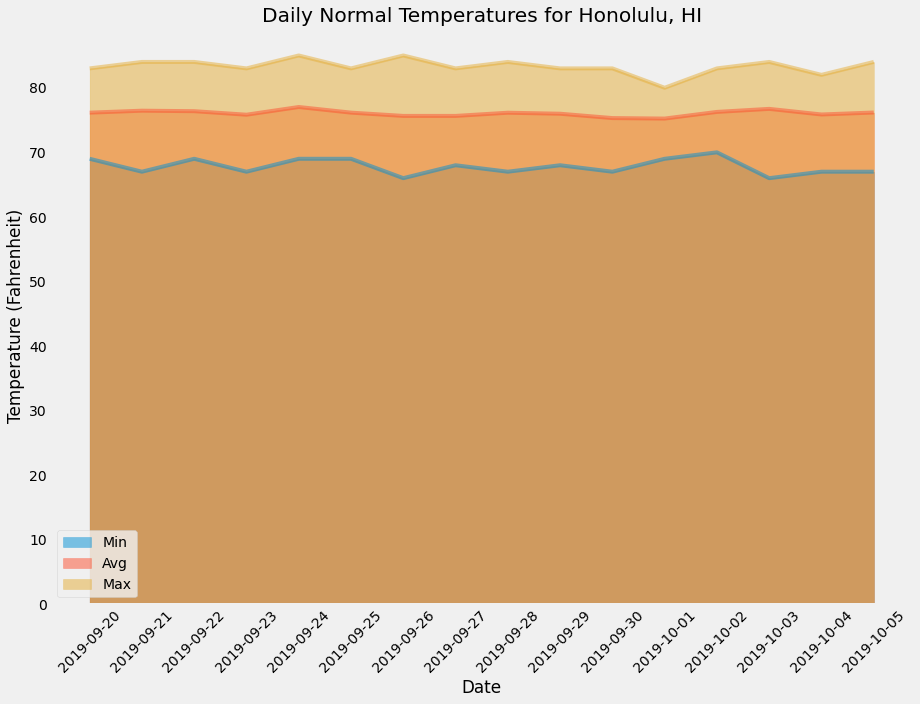

In [29]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots(figsize = (13, 10))
daily_norms_df.plot.area(ax = ax, stacked = False)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (Fahrenheit)')
ax.set_title('Daily Normal Temperatures for Honolulu, HI')

dates = [f"2019-{trip_date}" for trip_date in trip_dates]
ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(dates, rotation = 45)

#save figure
plt.savefig('Images/dailynormals.png')

#show
plt.grid()
plt.tight_layout()
plt.show()